# CSE 702 - Project "Community Interaction and Conflict on the Web"

In [2]:
# imports
import pickle
import json
import time
import glob
import praw
import pprint
import requests
from collections import Counter
from psaw import PushshiftAPI

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# ids2 = [i if i.startswith('t3_') else f't3_{i}' for i in ids]
# for ix in range(0, len(ids2), 499):
#     time.sleep(2)
#     print(ix, end="", flush=True)
#     for submission in reddit.info(ids2[ix:ix+499]):
#         res[submission.id] = []
#         for comment in submission.comments:
#             res[submission.id].append(comment)

In [ ]:
# for n, _id in enumerate(ids[87000:]):
#     print(n+87000, end="\r", flush=True)
#     if n%1000==0 and n!=0:
#         with open("comments_data.pkl", "wb") as f:
#             pickle.dump(res_2, f)
#         print(f"saved!->{n}\n")
#     res_2[_id] = {"submission": None, "comments": []}
#     tmp_gen = api.search_comments(link_id=_id, aggs="link_id", sort_type="created_utc", limit=5000, sort="asc")
#     try:
#         res_2[_id]["submission"] = next(tmp_gen).d_
#         res_2[_id]["comments"] = [comment.d_ for comment in tmp_gen]
#     except:
#         continue

In [36]:
df = pd.read_csv('detailed_data/label_info.tsv', sep='\t', header=None)

In [37]:
d_b = df[1].to_list()
d = df[0].to_list()

In [38]:
data= []
data_t = []
data_b = []
for n, i in enumerate(d):
    t = eval(i)
    data.append(t[0])
    data.append(t[1])
    data_t.append(t)
    data_b.append(d_b[n])

In [48]:
ids_set = set(ids)

In [49]:
present = []
bb_l = []
for ix in range(len(data_t)):
    if len(ids_set.intersection([data_t[ix][0], data_t[ix][1]]))==2:
        bb_l.append(data_b[ix])
        present.append([data_t[ix][0], data_t[ix][1]])
present = list(zip(bb_l, present))

In [52]:
Counter(bb_l)

Counter({'non-burst': 95285, 'burst': 5981})

# Building membership reference table

In [4]:
# with open("/Users/nikhilvasudeva/Downloads/posts_and_comments_new.json", "r") as f:
#     post_comments = f.readlines()

In [8]:
# read the posts and comments
with open('/Users/nikhilvasudeva/Downloads/CSE702-Project/posts_and_comments_all.json', 'r') as f:
    posts_comments = json.load(f)

In [13]:
# with open("/Users/nikhilvasudeva/Downloads/CSE702-Project/posts_and_comments_all.json", 'w') as f:
#     json.dump(post_comments, f)

In [ ]:
# SKIP
# code to fix json error, ignore if the file is fine.
posts_comments = []
for each in _posts_comments:
    try:
        posts_comments.append(json.loads(each.strip()))
    except:
        print(each)
        continue    
s = [json.dumps(i) for i in posts_comments]
s = list(set(s))
s = [json.loads(i) for i in s]
# with open('detailed_data/posts_and_comments.json', 'w') as f:
#     json.dump(s, f)

In [21]:
timestamps_of_all_posts = []
scrapped_ids = []
# r = []
for ix, each in enumerate(posts_comments):
    try:
        timestamps_of_all_posts.append(each[0]['created_utc'])
        scrapped_ids.append(each[0]['id'])
#         r.append(each)
    except:
        print(ix)

## Calculate memberships

In [23]:
subreddit_allcomments = {}
for each in posts_comments:
    if each[0]['subreddit_id'] not in subreddit_allcomments:
        subreddit_allcomments[each[0]['subreddit_id']] = []
    subreddit_allcomments[each[0]['subreddit_id']].extend([[e['created_utc'], e['author']] for e in each[1:]])

In [24]:
subreddit_posts = {}
for each in posts_comments:
    if each[0]['subreddit_id'] not in subreddit_posts:
        subreddit_posts[each[0]['subreddit_id']] = []
    subreddit_posts[each[0]['subreddit_id']].append(each[0])

In [25]:
member_day_list = {}
for subreddit_id, comments_time_authors in subreddit_allcomments.items():
    member_day_list[subreddit_id] = {}
    for comment_time_author in comments_time_authors:
        floor_time = comment_time_author[0] - comment_time_author[0]%86000
        if floor_time not in member_day_list[subreddit_id]:
            member_day_list[subreddit_id][floor_time] = []
        member_day_list[subreddit_id][floor_time].append(comment_time_author[1])    

In [26]:
# post to sub
post_sub = {}
for each in posts_comments:
    post_sub[each[0]['id']] = each[0]['subreddit_id']

In [27]:
postcomment_ref = {}
for each in posts_comments:
    postcomment_ref[each[0]['id']] = {'post': each[0], 'comments': each[1:]}

In [28]:
def get_all_members(utc_time, sub_id):
    """
    returns unique set of all active members in sub_id for the last 30 days.
    """
    members = []
    utc_time_thresh = utc_time - (utc_time%86000)
    for timestamp in range(utc_time_thresh-(86000*30), utc_time_thresh+(86000), 86000):
        try:
            members.extend(member_day_list[sub_id][timestamp])
        except KeyError:
            continue
    return [mem for mem in list(set(members)) if mem!='[deleted]']

In [152]:
def get_similar_post(utc_time, sub_id, tar_post_id, source_members_set):
    posts = [[each['id'], utc_time-each['created_utc']] for each in subreddit_posts[sub_id] if utc_time-each['created_utc']>=0 and each['id']!=tar_post_id]
    # TODO: Is a threshold required for calculating closest post for timestamp?
    posts = sorted(posts, key=lambda x: x[1])
    before_crosspost_count_target = len([each for each in postcomment_ref[tar_post_id]['comments'] if each['created_utc']<utc_time])
    after_crosspost_count_target = len([each for each in postcomment_ref[tar_post_id]['comments'] if each['created_utc']>utc_time and each['created_utc']<(utc_time+(3600*12))])

    tar_match = None
    tmp_after = 0
    for p in posts:
        tmp = len([each for each in postcomment_ref[p[0]]['comments'] if each['created_utc']<utc_time])
        if abs(before_crosspost_count_target - tmp) < 5:
            tmp_after = len([each for each in postcomment_ref[p[0]]['comments'] if each['created_utc']>utc_time and each['created_utc']<(utc_time+(3600*12))])
            # calculate source user comments
            tmp_smcip = [each['author'] for each in postcomment_ref[p[0]]['comments'] if each['created_utc']>utc_time and each['created_utc']<(utc_time+(3600*12))]
            tmp_smcit = [each['author'] for each in postcomment_ref[tar_post_id]['comments'] if each['created_utc']>utc_time and each['created_utc']<(utc_time+(3600*12))]
            source_mem_comments_in_p = len([each for each in tmp_smcip if each in source_members_set])
            source_mem_comments_in_tar = len([each for each in tmp_smcit if each in source_members_set])
#             matched post, tmp-lengthbefore, tmp_after - after crosslink, and same for target
            tar_match = [p[0], sub_id, tmp, tar_post_id, tmp_after, before_crosspost_count_target, after_crosspost_count_target, source_mem_comments_in_p, source_mem_comments_in_tar] # store the post id and the length of comments upto utc_time
            break
    if not tar_match:
        raise Exception(f"no match found for target {tar_post_id}")
        # TODO: return the results after 12 hours as well.
    return tar_match

In [ ]:
burst = [each for each in present if each[0]=="burst"]

In [153]:
before_after_results = []
counter = 0
for each in burst: 
    s, t = each[1][0], each[1][1]
    source_sub_id = post_sub[s]
    target_sub_id = post_sub[t]
    crosspostatsrc_uic = postcomment_ref[s]['post']['created_utc']
    source_members = get_all_members(crosspostatsrc_uic, source_sub_id)
    target_comment_authors = [c['author'] for c in postcomment_ref[t]['comments']] 
    try:
        before_after_results.append(get_similar_post(postcomment_ref[s]['post']['created_utc'], target_sub_id, t, set(source_members)))
        counter+=1
    except Exception as e:
        continue

In [158]:
fig_3_data = []
for each in before_after_results:
    if each[-2]>0:
        fig_3_data.append(each[-2:])

In [159]:
before = 0
after = 0
for each in fig_3_data:
    before += each[0]
    after+= each[1]

In [160]:
before/len(fig_3_data), after/len(fig_3_data)

(2.607142857142857, 4.767857142857143)

In [162]:
2.160714285714286/2.607142857142857

0.8287671232876713

In [163]:
len(fig_3_data)

56

In [164]:
len(burst)

5981

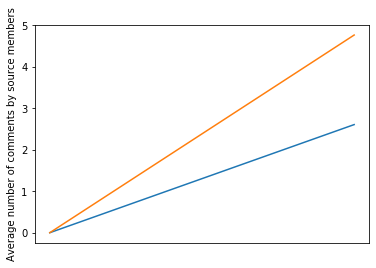

In [305]:
frm = plt.gca()
frm.get_xaxis().set_ticks([])
plt.plot([0, 2.607])
plt.plot([0, 4.767])
plt.ylabel('Average number of comments by source members')
plt.savefig("fig3")

In [189]:
all_burst_causers = []
for each in burst:
    all_burst_causers.append(post_sub[each[1][0]])

In [217]:
total = 0
unique = 0
fig4_data = []
for s, c in Counter(all_burst_causers).most_common():
    total+=c
    unique+=1
    fig4_data.append([(total/len(all_burst_causers))*100, unique/len(present)])

In [309]:
x, y = [], []
for each in fig4_data:
    x.append(each[0])
    y.append(each[1]*100)

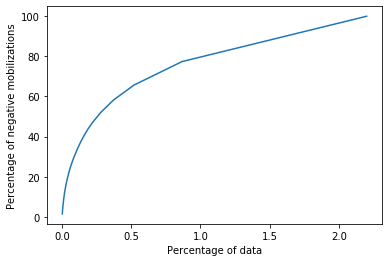

In [310]:
plt.plot(y, x)
plt.xlabel("Percentage of data")
plt.ylabel("Percentage of negative mobilizations")
plt.savefig("fig4")
plt.show()


In [ ]:
# 0.139 - responsible for most of the attacks

In [276]:
# calculate activity of the poster in relation to other members of the subreddit.
res = []
for each in burst:
    s = each[1][0]
    source_sub_id = post_sub[s]
    crosspostatsrc_uic = postcomment_ref[s]['post']['created_utc']
    post_author = postcomment_ref[s]['post']['author']
    source_members = get_all_members(crosspostatsrc_uic, source_sub_id)
    m = [each[1] for each in subreddit_allcomments[source_sub_id] if each[1]!="[deleted]" and each[0]<crosspostatsrc_uic]
    if not m:
        continue
    c = Counter(m)
    cm = c.most_common()
    s = 0
    for each in cm:
        s+=each[1]
    avg = s/len(cm)
    author_activity = c.get(post_author, 0)
    res.append([author_activity,avg])

In [275]:
sum(res)/len(res)

16.79341059872

In [268]:
res = [r/100 for r in res]

In [283]:
avg, pst, per = 0, 0, 0
for each in res:
    avg+=each[1]
    pst+=each[0]
    per+=(each[0]-each[1])/each[1]

In [278]:
avg/len(res), pst/len(res)

(3.729177456410164, 20.522588055130168)

In [284]:
per/len(res)

3.076083758040087

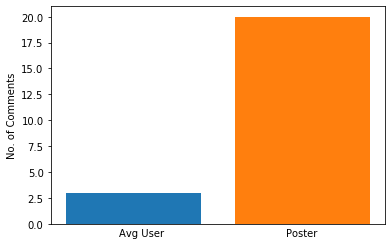

In [304]:
frame1 = plt.gca()
plt.bar(1, 3)
plt.bar(2, 20)
frame1.get_xaxis().set_ticks([])
plt.xlabel("Avg User                                       Poster")
plt.ylabel("No. of Comments")
plt.savefig("fig5")
plt.show()


In [301]:
len(post_comments)

225331